# Results 

## Description
In this notebook, we will compare multiple classifiers from different perspectives:
1. Accuracy vs. Imbalance
2. Risk curves
3. Losses vs. Iterations

The following classifiers are considered:
 - Bagging
 - AdaBoost
 - AdaCost
 - Boosting SVM?
 - AdaMEC
 - XGBoost



In [36]:
# Libraries
from classifiers import *
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
# from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [37]:
# Functions (if any)


### Load Data

In [115]:
scaler = StandardScaler()
data = pd.read_pickle("./data_no_cathegorical.pkl")

X = data.values[:,:-1]
scaler.fit(X)
X = scaler.transform(X)
Y = data.values[:,-1]

# Split data into train and test sets
seed = 10
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Labels for this algortihm has to be either 1 or -1
y_train = np.where(y_train < 0.5, -1, 1)
y_test = np.where(y_test < 0.5, -1, 1)

## Graph 1: Accuracy vs. Imbalance

In [82]:
# Get priors
prior0 = len(np.where(y_train==-1)[0])/len(y_train)
prior1 = len(np.where(y_train==1)[0])/len(y_train)
print(prior0,prior1)

0.7293164556962025 0.2706835443037975


In [83]:
# We will undersample class -1 until we revert the imbalance
X_train_0 = X_train[np.where(y_train==-1)[0],:]
X_train_1 = X_train[np.where(y_train==1)[0],:]
y_train_0 = y_train[np.where(y_train==-1)[0]]
y_train_1 = y_train[np.where(y_train==1)[0]]

x_train_sets = [np.r_[X_train_0[:int(len(X_train_0)*pctg),:], X_train_1] for pctg in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]]
y_train_sets = [np.r_[y_train_0[:int(len(X_train_0)*pctg)], y_train_1] for pctg in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]]

# Get new imbalances
imbalances = []
for y_train in y_train_sets:
    imbalances.append(len(np.where(y_train==-1)[0])/len(y_train))
print(imbalances)

[0.7080124528920203, 0.6830873199359773, 0.6534871661913404, 0.6178152702316271, 0.5739560089257252, 0.5186819123075538, 0.4469845867383883, 0.350109409190372, 0.21220159151193635]


In [84]:
# Get classifier for each imbalanced dataset
# ADABOOST
AdaBoost_set = [AdaBoostClassifier(n_estimators=100).fit(X_train,y_train) for X_train,y_train in zip(x_train_sets, y_train_sets)]
# AdaBoost_set = [AdaboostClassifier().fit(X_train,y_train) for X_train,y_train in zip(x_train_sets, y_train_sets)]

print('AdaBoost - OK')

AdaBoost - OK


In [85]:
# ADACOST
AdaCost_set = []
for X_train,y_train in zip(x_train_sets, y_train_sets):
    ac = AdaCost(n_iterations=100)
    ac.fit(X_train,y_train,cost=0.4)
    AdaCost_set.append(ac)
     
print('AdaCost - OK')

AdaCost - OK


In [86]:
# ADAMEC
AdaMEC_set = [AdaMEC(n_iterations=100).fit(X_train,y_train) for X_train,y_train in zip(x_train_sets, y_train_sets)]
print('AdaMEC - OK')


AdaMEC - OK


In [87]:
# XGBOOST
XGBoost_set = [XGBClassifier().fit(X_train,y_train) for X_train,y_train in zip(x_train_sets, y_train_sets)]
print('XGBoost - OK')

XGBoost - OK


In [88]:
# Bagging
Bagging_set = []
for X_train,y_train in zip(x_train_sets, y_train_sets):
    bagging_model = Bagging_classifier(type_classifier="SVM")
    bagging_model.fit(X_train,y_train)
    Bagging_set.append(bagging_model)
     
print('Bagging - OK')

# Random Forest
RandomForest_set = [RandomForestClassifier(max_depth=2, random_state=0, n_estimators = 100).fit(X_train, y_train) for X_train,y_train in zip(x_train_sets, y_train_sets)]
print('Random Forest - OK')

Bagging - OK
Random Forest - OK


In [64]:
# Boosting SVM
BoostingSVM_set = []
for X_train,y_train in zip(x_train_sets, y_train_sets):
    
    N = len(y_train)
    dataset_train = np.c_[X_train,y_train]
    
#     print(np.shape(X_train))
    
    dataset_train_special = dataset_train[random.sample(range(1, int(N)),int(0.5*N)), :]
    X_train_special = dataset_train_special[:,0:58]
    y_train_special = dataset_train_special[:,58]
    
#     print(np.shape(X_train_special))

    
    BoostingSVM_model = BoostingSVM()
    BoostingSVM_model.fit(X_train_special,y_train_special)
#     BoostingSVM_model.fit(X_train,y_train)
    BoostingSVM_set.append(BoostingSVM_model)

print('Boosting SVM - OK')

Sigma: 50.0
Sigma: 50.0
Sigma: 49.5
Sigma: 49.0
Sigma: 48.5
Sigma: 48.0
Sigma: 47.5
Sigma: 47.0
Sigma: 46.5
Sigma: 46.0
Sigma: 45.5
Sigma: 45.0
Sigma: 44.5
Sigma: 44.0
Sigma: 43.5
Sigma: 43.0
Sigma: 42.5
Sigma: 42.0
Sigma: 41.5
Sigma: 41.0
Sigma: 40.5
Sigma: 40.0
Sigma: 39.5
Sigma: 39.0
Sigma: 38.5
Sigma: 38.0
Sigma: 37.5
Sigma: 37.0
Sigma: 36.5
Sigma: 36.0
Sigma: 35.5
Sigma: 35.0
Sigma: 34.5
Sigma: 34.0
Sigma: 33.5
Sigma: 33.0
Sigma: 32.5
Sigma: 32.0
Sigma: 31.5
Sigma: 31.0
Sigma: 30.5
Sigma: 30.0
Sigma: 29.5
Sigma: 29.0
Sigma: 28.5
Sigma: 28.0
Sigma: 27.5
Sigma: 27.0
Sigma: 26.5
Sigma: 26.0
Sigma: 25.5
Sigma: 25.0
Sigma: 24.5
Sigma: 24.0
Sigma: 23.5
Sigma: 23.0
Sigma: 22.5
Sigma: 22.0
Sigma: 21.5
Sigma: 21.0
Sigma: 20.5
Sigma: 20.0
Sigma: 19.5
Sigma: 19.0
Sigma: 18.5
Sigma: 18.0
Sigma: 17.5
Sigma: 17.0
Sigma: 16.5
Sigma: 16.0
Sigma: 15.5
Sigma: 15.0
Sigma: 14.5
Sigma: 14.0
Sigma: 13.5
Sigma: 13.0
Sigma: 12.5
Sigma: 12.0
Sigma: 11.5
Sigma: 11.0
Sigma: 10.5
Sigma: 50.0
Sigma: 50.0
Sigm

Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigm

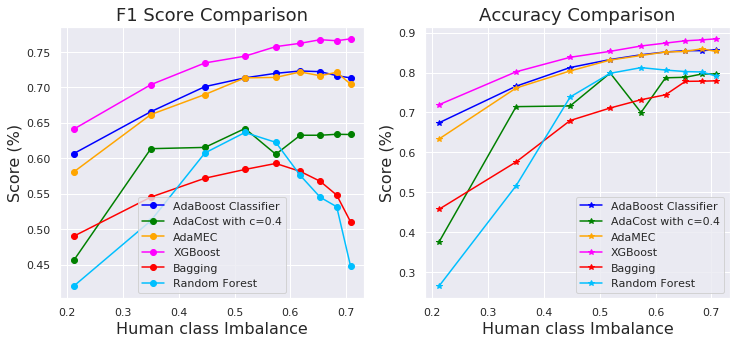

In [89]:
classifier_label = ['AdaBoost Classifier', 'AdaCost with c=0.4','AdaMEC','XGBoost','Bagging','Random Forest']
classifier_color = ['blue','green','orange','magenta','red','Deepskyblue']
cont = 0

f = plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for classifiers in [AdaBoost_set, AdaCost_set, AdaMEC_set, XGBoost_set, Bagging_set,RandomForest_set]:
    acc = []
    f1 = []
    # Calculate accuracies
    for classifier in classifiers:
        acc.append(accuracy_score(classifier.predict(X_test),y_test))
        f1.append(f1_score(classifier.predict(X_test),y_test))
        
    ax1.plot(imbalances, f1,'-o', color = classifier_color[cont],label = classifier_label[cont])
    ax2.plot(imbalances, acc,'-*', color = classifier_color[cont],label = classifier_label[cont])
    
    cont += 1

ax1.set_title('F1 Score Comparison', fontsize = 18)
ax2.set_title('Accuracy Comparison', fontsize = 18)
ax1.set_xlabel('Human class Imbalance', fontsize = 16)
ax2.set_xlabel('Human class Imbalance', fontsize = 16)
ax1.set_ylabel('Score (%)', fontsize = 16)
ax2.set_ylabel('Score (%)', fontsize = 16)
ax1.legend()
ax2.legend()
# plt.savefig('../WriteUp/pictures/Imbalance_Comparison.png')
plt.show()


### Graph 2: Risk curves

In [90]:
scaler = StandardScaler()
data = pd.read_pickle("./data_no_cathegorical.pkl")

X = data.values[:,:-1]
scaler.fit(X)
X = scaler.transform(X)
Y = data.values[:,-1]

# Split data into train and test sets
seed = 10
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Labels for this algortihm has to be either 1 or -1
y_train = np.where(y_train < 0.5, -1, 1)
y_test = np.where(y_test < 0.5, -1, 1)

In [91]:
n_learners_list = [1,5,10,20,50,75,100,150,200]

In [92]:
# ADABOOST
# AdaBoost_set = [AdaBoostClassifier(n_estimators = n_learners).fit(X_train,y_train) for n_learners in n_learners_list]
AdaBoost_set = []
for n_learners in n_learners_list:
    ab = AdaboostClassifier(n_iterations=n_learners)
    ab.fit(X_train,y_train)
    AdaBoost_set.append(ab)
    
print('AdaBoost - OK')

# ADACOST
AdaCost_set = []
for n_learners in n_learners_list:
    ac = AdaCost(n_iterations=n_learners)
    ac.fit(X_train,y_train,cost=-0.4)
    AdaCost_set.append(ac)
     
print('AdaCost - OK')

# ADAMEC
AdaMEC_set = [AdaMEC(n_iterations=n_learners).fit(X_train,y_train) for n_learners in n_learners_list]
print('AdaMEC - OK')

# XGBOOST
XGBoost_set = [XGBClassifier(n_estimators=n_learners).fit(X_train,y_train) for n_learners in n_learners_list]
print('XGBoost - OK')

# Bagging
Bagging_set = []
for n_learners in n_learners_list:
    bagging_model = Bagging_classifier(type_classifier="SVM",n_iterations = n_learners)
    bagging_model.fit(X_train,y_train)
    Bagging_set.append(bagging_model)
     
print('Bagging - OK')

# Random Forest
RandomForest_set = [RandomForestClassifier(max_depth=2, random_state=0, n_estimators = n_learners).fit(X_train, y_train) for n_learners in n_learners_list]

print('RandomForest - OK')


# Boosting SVM

BoostingSVM_set = []
X_train_special = X_train[:int(len(X_train)*0.3),:]
y_train_special = y_train[:int(len(y_train)*0.3)]
for n_learners in n_learners_list:
    BoostingSVM_model = BoostingSVM(n_estimators = n_learners)
    BoostingSVM_model.fit(X_train_special,y_train_special)  
    BoostingSVM_set.append(BoostingSVM_model)

print('Boosting SVM - OK')



AdaBoost - OK
AdaCost - OK
AdaMEC - OK
XGBoost - OK
Bagging - OK
RandomForest - OK
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 49.5
Sigma: 49.0
Sigma: 48.5
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 49.5
Sigma: 49.0
Sigma: 48.5
Sigma: 48.0
Sigma: 47.5
Sigma: 47.0
Sigma: 46.5
Sigma: 46.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 49.5
Sigma: 49.0
Sigma: 48.5
Sigma: 48.0
Sigma: 47.5
Sigma: 47.0
Sigma: 46.5
Sigma: 46.0
Sigma: 45.5
Sigma: 45.0
Sigma: 44.5
Sigma: 44.0
Sigma: 43.5
Sigma: 43.0
Sigma: 42.5
Sigma: 42.0
Sigma: 41.5
Sigma: 41.0
Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 49.5
Sigma: 49.0
Sigma: 48.5
Sigma: 48.0
Sigma: 47.5
Sigma: 47.0
Sigma: 46.5
Sigma: 46.0
Sigma: 45.5
Sigma: 45.0
Sigma: 44.5
Sigma: 44.0
Sigma: 43.5
Sigma: 43.0
Sigma: 42.5
Sigma: 42.0
Sigma: 41.5
Sigma: 41.0
Sigma: 40.5
Sigma: 40.0
Sigma: 39.5
Sigma: 39.0
Sigma: 38.5
Sigma: 38.0
Sigma: 37.5
Sigma: 37.0
Sigma: 36.5
Sigma: 36.0
Sigma: 35.5
Sigma: 35.0
Sigma: 34.5
Sigma: 34.0
Sigma: 33.5
Sigma

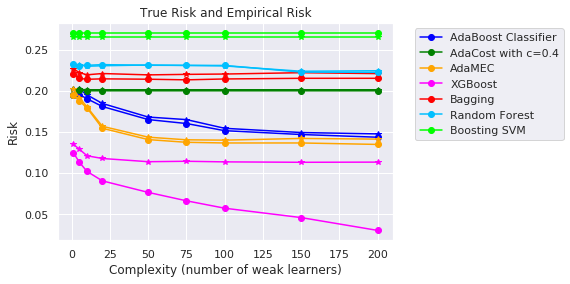

In [93]:
classifier_label = ['AdaBoost Classifier', 'AdaCost with c=0.4','AdaMEC','XGBoost','Bagging','Random Forest','Boosting SVM']
classifier_color = ['blue','green','orange','magenta','red','Deepskyblue','Lime']
cont = 0
plt.figure()
for classifiers in [AdaBoost_set, AdaCost_set, AdaMEC_set, XGBoost_set, Bagging_set,RandomForest_set,BoostingSVM_set]:

    empirical_risk_list = []
    true_risk_list = []
    # Calculate accuracies
    for classifier in classifiers:
        
        incorrect_pred_emp = 0
        incorrect_pred_true = 0
        
        pred_train = classifier.predict(X_train)
        
        for item in range(np.shape(X_train)[0]):
            
            if pred_train[item] != y_train[item]:
                incorrect_pred_emp = incorrect_pred_emp + 1
        
        emp_risk =  incorrect_pred_emp/len(X_train)
        
        
        pred_test = classifier.predict(X_test)
        
        for item in range(np.shape(X_test)[0]):
            
            if pred_test[item] != y_test[item]:
                incorrect_pred_true = incorrect_pred_true + 1
        
        true_risk =  incorrect_pred_true/len(X_test)       
        
        
        empirical_risk_list.append(emp_risk)
        true_risk_list.append(true_risk)
        
        
    plt.plot(n_learners_list, empirical_risk_list,'-o', color = classifier_color[cont],label = classifier_label[cont])
    plt.plot(n_learners_list, true_risk_list,'-*', color = classifier_color[cont]) #,label = classifier_label[cont]
   
    cont += 1

plt.title('True Risk and Empirical Risk')
plt.xlabel('Complexity (number of weak learners)')
plt.ylabel('Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Graph 3: Losses vs. Iterations

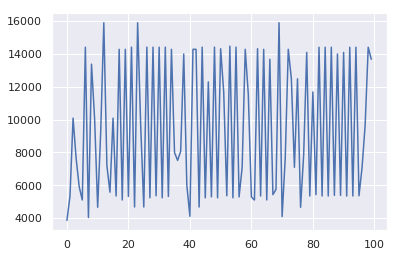

In [10]:
# ADABOOST

AdaBoost_classifier = AdaboostClassifier(n_iterations=100)
AdaBoost_classifier.fit(X_train,y_train)

AdaBoost_loss = AdaBoost_classifier.loss_vec
plt.plot(AdaBoost_loss)
plt.show()

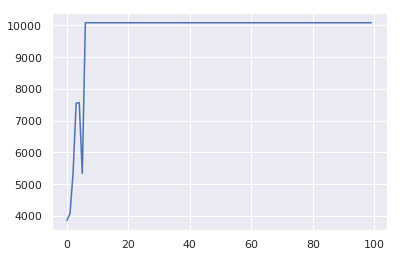

In [12]:
# ADACOST

AdaCost_classifier = AdaCost(n_iterations=100)
AdaCost_classifier.fit(X_train,y_train,cost=-0.4)

AdaCost_loss = AdaCost_classifier.loss_vec
plt.plot(AdaCost_loss)
plt.show()

Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 49.5
Sigma: 49.0
Sigma: 48.5
Sigma: 48.0
Sigma: 47.5
Sigma: 47.0
Sigma: 46.5
Sigma: 46.0
Sigma: 45.5
Sigma: 45.0
Sigma: 44.5
Sigma: 44.0
Sigma: 43.5
Sigma: 43.0
Sigma: 42.5
Sigma: 42.0
Sigma: 41.5
Sigma: 41.0
Sigma: 40.5
Sigma: 40.0
Sigma: 39.5
Sigma: 39.0
Sigma: 38.5
Sigma: 38.0
Sigma: 37.5
Sigma: 37.0
Sigma: 36.5
Sigma: 36.0
Sigma: 35.5
Sigma: 35.0
Sigma: 34.5
Sigma: 34.0
Sigma: 33.5
Sigma: 33.0
Sigma: 32.5
Sigma: 32.0
Sigma: 31.5
Sigma: 31.0
Sigma: 30.5
Sigma: 30.0
Sigma: 29.5
Sigma: 29.0
Sigma: 28.5
Sigma: 28.0
Sigma: 27.5
Sigma: 27.0
Sigma: 26.5
Sigma: 26.0
Sigma: 25.5
Sigma: 25.0
Sigma: 24.5
Sigma: 24.0
Sigma: 23.5
Sigma: 23.0
Sigma: 22.5
Sigma: 22.0
Sigma: 21.5
Sigma: 21.0
Sigma: 20.5
Sigma: 20.0
Sigma: 19.5
Sigma: 19.0
Sigma: 18.5
Sigma: 18.0
Sigma: 17.5
Sigma: 17.0
Sigma: 16.5
Sigma: 16.0
Sigma: 15.5
Sigma: 15.0
Sigma: 14.5
Sigma: 14.0
Sigma: 13.5
Sigma: 13.0
Sigma: 12.5
Sigma: 12.0
Sigma: 11.5
Sigma: 11.0
Sigma: 10.5


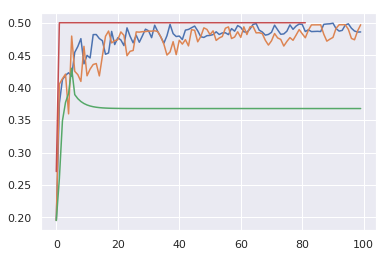

In [10]:
AdaBoost_classifier = AdaBoostClassifier(n_estimators=100)
AdaBoost_classifier.fit(X_train,y_train)

Adaboost_classifier = AdaboostClassifier(n_iterations=100)
Adaboost_classifier.fit(X_train,y_train)

AdaCost_classifier = AdaCost(n_iterations=100)
AdaCost_classifier.fit(X_train,y_train,cost=-0.4)

AdaMEC_classifier = AdaMEC(n_iterations=100)
hola = AdaMEC_classifier.fit(X_train,y_train)
# AdaMEC_classifier.AdaBoostUncal
# AdaMEC_classifier.fit(X_train,y_train)

BoostingSVM_classifier = BoostingSVM()
BoostingSVM_classifier.fit(X_train,y_train)


In [ ]:
plt.plot(AdaBoost_classifier.estimator_errors_)
plt.plot(Adaboost_classifier.error_vec)
plt.plot(AdaCost_classifier.error_vec)
# plt.plot(AdaMEC_classifier.error_vec)
plt.plot(BoostingSVM_classifier.error_vec)

plt.show()

### Perfomance results

In [105]:
def auc_score(y_true,y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    return metrics.auc(fpr, tpr)

In [106]:
def print_metrics(name_algortihm, classifier):
    print(name_algortihm)
    print("F1 score: " + str(f1_score(y_test,classifier.predict(X_test), average = 'binary',pos_label=1)))
    print("Accuracy: " + str(accuracy_score(y_test,classifier.predict(X_test))))
    print("Precision: " + str(precision_score(y_test, classifier.predict(X_test),average= 'binary',pos_label=1)))
    print("Recall: " + str(recall_score(y_test, classifier.predict(X_test),average= 'binary',pos_label=1)))
    print("AUC: " + str(auc_score(y_test, classifier.predict(X_test))))

#### Ensemble

In [116]:
# ADABOOST
AdaBoost_classifier = AdaboostClassifier(n_iterations=100)
AdaBoost_classifier.fit(X_train,y_train)
print_metrics("ADABOOST",AdaBoost_classifier)

# BAGGING
bagging_classifier = Bagging_classifier(type_classifier="SVM")
bagging_classifier.fit(X_train,y_train)

print_metrics("BAGGING",bagging_classifier)

# RANDOM FOREST
RandomForest_Classifier = RandomForestClassifier(max_depth=2, random_state=0)
RandomForest_Classifier.fit(X_train, y_train)

print_metrics("RANDOM FOREST",RandomForest_Classifier)

# XGBOOST
XGBoost_classifier = XGBClassifier(n_estimators=100)
XGBoost_classifier.fit(X_train,y_train)

print_metrics("XGBOOST",XGBoost_classifier)


BAGGING
F1 score: 0.4998829861923707
Accuracy: 0.7803474149450098
Precision: 0.6327014218009479
Recall: 0.41315280464216636
AUC: 0.6631833452102209


In [117]:
#BOOSTING SVM
BoostingSVM_classifier = BoostingSVM()
BoostingSVM_classifier.fit(X_train,y_train)
print_metrics("BOOSTING SVM",BoostingSVM_classifier)

Sigma: 50.0
Sigma: 50.0
Sigma: 50.0
Sigma: 49.5
Sigma: 49.0
Sigma: 48.5
Sigma: 48.0
Sigma: 47.5
Sigma: 47.0
Sigma: 46.5
Sigma: 46.0
Sigma: 45.5
Sigma: 45.0
Sigma: 44.5
Sigma: 44.0
Sigma: 43.5
Sigma: 43.0
Sigma: 42.5
Sigma: 42.0
Sigma: 41.5
Sigma: 41.0
Sigma: 40.5
Sigma: 40.0
Sigma: 39.5
Sigma: 39.0
Sigma: 38.5
Sigma: 38.0
Sigma: 37.5
Sigma: 37.0
Sigma: 36.5
Sigma: 36.0
Sigma: 35.5
Sigma: 35.0
Sigma: 34.5
Sigma: 34.0
Sigma: 33.5
Sigma: 33.0
Sigma: 32.5
Sigma: 32.0
Sigma: 31.5
Sigma: 31.0
Sigma: 30.5
Sigma: 30.0
Sigma: 29.5
Sigma: 29.0
Sigma: 28.5
Sigma: 28.0
Sigma: 27.5
Sigma: 27.0
Sigma: 26.5
Sigma: 26.0
Sigma: 25.5
Sigma: 25.0
Sigma: 24.5
Sigma: 24.0
Sigma: 23.5
Sigma: 23.0
Sigma: 22.5
Sigma: 22.0
Sigma: 21.5
Sigma: 21.0
Sigma: 20.5
Sigma: 20.0
Sigma: 19.5
Sigma: 19.0
Sigma: 18.5
Sigma: 18.0
Sigma: 17.5
Sigma: 17.0
Sigma: 16.5
Sigma: 16.0
Sigma: 15.5
Sigma: 15.0
Sigma: 14.5
Sigma: 14.0
Sigma: 13.5
Sigma: 13.0
Sigma: 12.5
Sigma: 12.0
Sigma: 11.5
Sigma: 11.0
Sigma: 10.5
BOOSTING SVM
F1 

/home/miguel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
AUC: 0.5


#### Cost sensitive

In [110]:
# ADACOST
AdaCost_classifier = AdaCost(n_iterations=100)
AdaCost_classifier.fit(X_train,y_train,cost=0.4)

print_metrics("ADACOST",AdaCost_classifier)

# ADAMEC
AdaMEC_classifier = AdaMEC(n_iterations=100)
AdaMEC_classifier = AdaMEC_classifier.fit(X_train,y_train)

# AdaMEC_classifier.predict(X_test)

print_metrics("ADAMEC",AdaMEC_classifier)

ADACOST
F1 score: 0.5953869368398361
Accuracy: 0.8070716414842224
Precision: 0.6723466407010711
Recall: 0.5342359767891682
AUC: 0.7200155247887611
ADAMEC
F1 score: 0.7099091485315866
Accuracy: 0.8588755267756193
Precision: 0.7821229050279329
Recall: 0.6499032882011605
AUC: 0.7921968848620583


####  Hybrid

In [111]:
X_train_majority = X_train[y_train < 1] # human (non-bots) => label -1 : are majority
X_train_minority = X_train[y_train > 0]

N = np.shape(y_train)[0]
pi_mi = len(X_train_minority)/np.shape(y_train)[0]

# X_train_majority = X_train_majority.to_numpy()
# X_train_minority = X_train_minority.to_numpy()

# y_test = np.where(y_test < 0.5, -1, 1)

y_train = y_train.flatten()
y_test = y_test.flatten()

In [112]:
pi_mi

0.2706835443037975

In [113]:
def get_undersampled_dataset(Beta):
    X_train_majority_undersampled = X_train_majority[random.sample(range(1, int((1-pi_mi)*N)),int(Beta*(1-pi_mi)*N)), :]
    X_train_under = np.r_[X_train_majority_undersampled,X_train_minority]
    y_train_under = np.r_[[-1]*len(X_train_majority_undersampled), [1]*len(X_train_minority)]
    
    return X_train_under, y_train_under

In [114]:
# ADABOOST
X_train_under, y_train_under = get_undersampled_dataset(0.62)
AdaBoost_classifier_under = AdaboostClassifier(n_iterations=100)
AdaBoost_classifier_under.fit(X_train_under,y_train_under)
print_metrics("ADABOOST",AdaBoost_classifier_under)
# BAGGING
X_train_under, y_train_under = get_undersampled_dataset(0.58)
bagging_classifier_under = Bagging_classifier(type_classifier="SVM")
bagging_classifier_under.fit(X_train_under,y_train_under)
print_metrics("BAGGING",bagging_classifier_under)
# RANDOM FOREST
X_train_under, y_train_under = get_undersampled_dataset(0.52)
RandomForest_Classifier_under = RandomForestClassifier(max_depth=2, random_state=0)
RandomForest_Classifier_under.fit(X_train_under, y_train_under)
print_metrics("RANDOM FOREST",RandomForest_Classifier_under)
# XGBOOST
X_train_under, y_train_under = get_undersampled_dataset(0.7)
XGBoost_classifier_under = XGBClassifier(n_estimators=100)
XGBoost_classifier_under.fit(X_train_under,y_train_under)
print_metrics("XGBOOST",XGBoost_classifier_under)
# ADACOST
X_train_under, y_train_under = get_undersampled_dataset(0.52)
AdaCost_classifier_under = AdaCost(n_iterations=100)
AdaCost_classifier_under.fit(X_train_under,y_train_under,cost=-0.4)
print_metrics("ADACOST",AdaCost_classifier_under)
# ADAMEC
X_train_under, y_train_under = get_undersampled_dataset(0.65)
AdaMEC_classifier_under = AdaMEC(n_iterations=100)
AdaMEC_classifier_under = AdaMEC_classifier_under.fit(X_train_under,y_train_under)
print_metrics("ADAMEC",AdaMEC_classifier_under)

ADABOOST
F1 score: 0.6903323262839879
Accuracy: 0.8314318018295817
Precision: 0.6742899299151605
Recall: 0.7071566731141199
AUC: 0.791778224574977
BAGGING
F1 score: 0.5927727588603197
Accuracy: 0.7590708192003289
Precision: 0.5380006307158625
Recall: 0.6599613152804642
AUC: 0.7274470630153721
RANDOM FOREST
F1 score: 0.6082755723587482
Accuracy: 0.8083050673244938
Precision: 0.6654411764705882
Recall: 0.5601547388781432
AUC: 0.7291255217347044
XGBOOST
F1 score: 0.7669172932330828
Accuracy: 0.8789186966800288
Precision: 0.7849331713244229
Recall: 0.7497098646034817
AUC: 0.8376908785503411
ADACOST
F1 score: 0.5751054852320674
Accuracy: 0.7929900298077911
Precision: 0.6324825986078886
Recall: 0.5272727272727272
AUC: 0.7082052326173267
ADAMEC
F1 score: 0.7097400077609625
Accuracy: 0.8462329119128379
Precision: 0.711950175165434
Recall: 0.7075435203094778
AUC: 0.801980046828871
